# Finding blobs in 64x64 images using Unet, trained on masks and outlines

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from PIL import Image
import random

# Get data

Data reading function

In [2]:
def read_tiff(path, n_images):
    """
    path - Path to the multipage-tiff file
    n_images - Number of pages in the tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(n_images):
        try:
            img.seek(i)
            slice_ = np.zeros((img.height, img.width))
            for j in range(slice_.shape[0]):
                for k in range(slice_.shape[1]):
                    slice_[j,k] = img.getpixel((j, k))

            images.append(slice_)

        except EOFError:
            # Not enough frames in img
            break

    return np.array(images)

In [3]:
def leaky_relu(inp, alpha=0.2):
    return tf.maximum(inp * alpha, inp)
    

Read in blobs tiff

In [4]:
all_dataA=read_tiff('BorderlessBlobs.tif',10000)
#all_dataB=read_tiff('CountBlobsB.tif',10000)
#all_dataC=read_tiff('CountBlobsC.tif',10000)

In [5]:
all_truthsA=read_tiff('BorderlessBlobsTruth.tif',10000)

#dfB=pd.read_csv('CountBlobsTruthB.csv')
#dfC=pd.read_csv('CountBlobsTruthC.csv')

In [6]:
all_truthsB=read_tiff('BorderlessBlobsOutlineTruth.tif',10000)

Read in truth table

# Design network

Define a function to create a convolutional layer, including conv, relu, maxpool, that can be called multiple times

In [7]:
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 64,64])
y=tf.placeholder(dtype=tf.float32, shape=[None, 64,64,2])

xr=tf.reshape(x, [-1, 64,64,1])
yr=y

base_scaler=64

#Going down
A1=leaky_relu(tf.layers.conv2d(xr, base_scaler, [3,3], padding='SAME'))
A2=leaky_relu(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME'))

B0=tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=leaky_relu(tf.contrib.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME'))
B2=leaky_relu(tf.contrib.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME'))

C0=tf.nn.max_pool(B2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=leaky_relu(tf.contrib.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME'))
C2=leaky_relu(tf.contrib.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME'))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=leaky_relu(tf.contrib.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME'))
D2=leaky_relu(tf.contrib.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME'))

E0=tf.nn.max_pool(D2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
E1=leaky_relu(tf.contrib.layers.conv2d(E0, 16*base_scaler, [3,3], padding='SAME'))
E2=leaky_relu(tf.contrib.layers.conv2d(E1, 16*base_scaler, [3,3], padding='SAME'))

#Put in a dense layer, probably not a good idea
using_fully_connected=0
if using_fully_connected==1:
    flattened=tf.reshape(E2, [-1,16*base_scaler*4*4 ])
    dense1=tf.contrib.layers.fully_connected(flattened,128)
    dense2=tf.contrib.layers.fully_connected(dense1,16*base_scaler*4*4)
    unflattened=tf.reshape(dense2, [-1, 4,4,16*base_scaler])
    DD0=tf.contrib.layers.conv2d_transpose(unflattened, 8*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
else:
    DD0=tf.contrib.layers.conv2d_transpose(E2, 8*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')

#Coming up
DD1=tf.concat(axis=3, values=[DD0,D2])
DD2=leaky_relu(tf.contrib.layers.conv2d(DD1, 8*base_scaler, [3,3], padding='SAME'))
DD3=leaky_relu(tf.contrib.layers.conv2d(DD2, 8*base_scaler, [3,3], padding='SAME'))

CC0=tf.contrib.layers.conv2d_transpose(DD3, 4*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
CC1=tf.concat(axis=3, values=[CC0,C2])
CC2=leaky_relu(tf.contrib.layers.conv2d(CC1, 4*base_scaler, [3,3], padding='SAME'))
CC3=leaky_relu(tf.contrib.layers.conv2d(CC2, 4*base_scaler, [3,3], padding='SAME'))

BB0=tf.contrib.layers.conv2d_transpose(CC3, 2*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
BB1=tf.concat(axis=3, values=[BB0,B2])
BB2=leaky_relu(tf.contrib.layers.conv2d(BB1, 2*base_scaler, [3,3], padding='SAME'))
BB3=leaky_relu(tf.contrib.layers.conv2d(BB2, 2*base_scaler, [3,3], padding='SAME'))

AA0=tf.contrib.layers.conv2d_transpose(BB3, base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
AA1=tf.concat(axis=3, values=[AA0,A2])
AA2=leaky_relu(tf.contrib.layers.conv2d(AA1, base_scaler, [3,3], padding='SAME'))
AA3=leaky_relu(tf.contrib.layers.conv2d(AA2, base_scaler, [3,3], padding='SAME'))

logits=leaky_relu(tf.contrib.layers.conv2d(AA3, 2, [1,1], padding='SAME'))
probs=tf.tanh(logits)

diff=tf.subtract(probs, yr)
LSQ=tf.multiply(diff,diff)
loss=tf.reduce_mean(LSQ)

train_op=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)



# Training on easy set

In [8]:
all_data=(all_dataA)/255.0

train_data=all_data[0:6000, :,:]
validation_data=all_data[6001:8000, :,:]
test_data=all_data[8001:10000, :,:]

In [9]:
all_truths=np.concatenate((all_truthsA.reshape([10000,64,64,1]), all_truthsB.reshape([10000, 64, 64, 1])), axis=3)/255.0

train_truth=all_truths[0:6000, :,:,:]
validation_truth=all_truths[6001:8000, :,:, :]
test_truth=all_truths[8001:10000, :,:, :]

In [25]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(500):
    idx=np.random.choice(6000, replace=False, size=[40])
    cur_train=train_data[idx,:,:]
    cur_truth=train_truth[idx,:,:]
    _,results, LN,losses=sess.run([train_op, logits, probs, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%10==0):
        print("Error rate: ", logits.shape)
        print("Real loss: ",losses)

Error rate:  (?, 64, 64, 2)
Real loss:  0.06393328
Error rate:  (?, 64, 64, 2)
Real loss:  0.06220306
Error rate:  (?, 64, 64, 2)
Real loss:  0.06373682
Error rate:  (?, 64, 64, 2)
Real loss:  0.06368386
Error rate:  (?, 64, 64, 2)
Real loss:  0.06138313
Error rate:  (?, 64, 64, 2)
Real loss:  0.060998477
Error rate:  (?, 64, 64, 2)
Real loss:  0.059038524
Error rate:  (?, 64, 64, 2)
Real loss:  0.062081877
Error rate:  (?, 64, 64, 2)
Real loss:  0.05998147
Error rate:  (?, 64, 64, 2)
Real loss:  0.060468476
Error rate:  (?, 64, 64, 2)
Real loss:  0.062295098
Error rate:  (?, 64, 64, 2)
Real loss:  0.061237082
Error rate:  (?, 64, 64, 2)
Real loss:  0.059612405
Error rate:  (?, 64, 64, 2)
Real loss:  0.059482746
Error rate:  (?, 64, 64, 2)
Real loss:  0.058951512
Error rate:  (?, 64, 64, 2)
Real loss:  0.058740478
Error rate:  (?, 64, 64, 2)
Real loss:  0.05800752
Error rate:  (?, 64, 64, 2)
Real loss:  0.06215278
Error rate:  (?, 64, 64, 2)
Real loss:  0.056679092
Error rate:  (?, 64,

# Check validation

In [73]:
sub_range=range(0,100)
sub_validation_data=validation_data[sub_range, :,:]
sub_validation_truth=validation_truth[sub_range, :,:, :]
results, LN,losses=sess.run([probs, LSQ, loss], feed_dict={x:sub_validation_data, y:sub_validation_truth})
losses

0.05410435

10


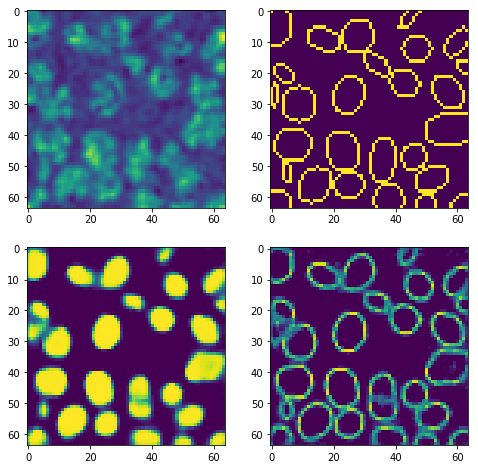

In [75]:
f,axes=plt.subplots(2,2, figsize=(8,8))
ix=random.randint(1,64)
print(ix)
axes[0,0].imshow(sub_validation_data[ix,:,:])
axes[0,1].imshow(sub_validation_truth[ix,:,:,1])
axes[1,0].imshow((0.01+results[ix,:,:,0]))
axes[1,1].imshow((0.01+results[ix,:,:,1]))




# Check on real images

Trying on Imagej's "Blobs" image

In [90]:
blobs=plt.imread('BlobsB.tif')
blobs=blobs.reshape([1,64,64])
blobs=(blobs-np.mean(blobs))/np.std(blobs)
blobs=((blobs*.05+0.5))
blobgarb=sub_validation_truth[0,:,:,:].reshape([1,64,64,2])
print(np.mean(blobs))
print(np.std(blobs))

0.5
0.05


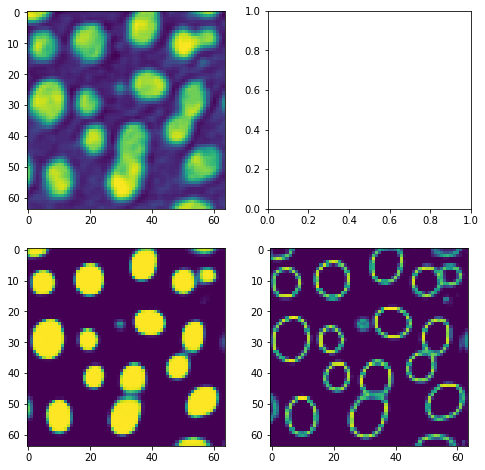

In [91]:
results, LN,losses=sess.run([probs, LSQ, loss], feed_dict={x:blobs, y:blobgarb})
f,axes=plt.subplots(2,2, figsize=(8,8))
axes[0,0].imshow(blobs[0,:,:])
#axes[0,1].imshow(blobgarb[0,:,:,1])
axes[1,0].imshow((0.01+results[0,:,:,0]))
axes[1,1].imshow((0.01+results[0,:,:,1]))

Trying on Cheng-Yi's Stella images of nucleii

In [92]:
blobs=plt.imread('BlobsC.tif')
blobs=blobs.reshape([1,64,64])
blobs=(blobs-np.mean(blobs))/np.std(blobs)
blobs=((blobs*.05+0.5))
blobgarb=sub_validation_truth[0,:,:,:].reshape([1,64,64,2])
print(np.mean(blobs))
print(np.std(blobs))

0.5
0.05


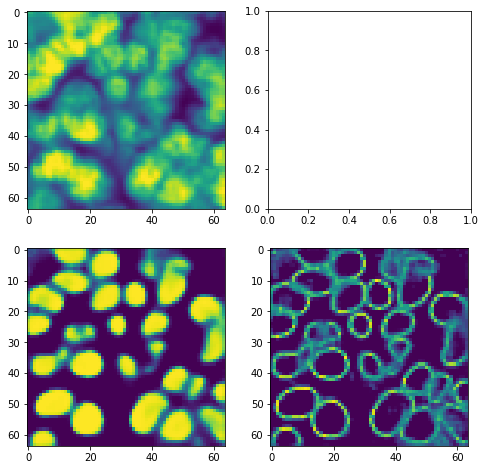

In [93]:
results, LN,losses=sess.run([probs, LSQ, loss], feed_dict={x:blobs, y:blobgarb})
f,axes=plt.subplots(2,2, figsize=(8,8))
axes[0,0].imshow(blobs[0,:,:])
#axes[0,1].imshow(blobgarb[0,:,:,1])
axes[1,0].imshow((0.01+results[0,:,:,0]))
axes[1,1].imshow((0.01+results[0,:,:,1]))

In [94]:
sub_validation_data.shape

(100, 64, 64)

In [140]:
blobs=read_tiff('BonyBlobsStack.tif',33)
#blobs=blobs.reshape([1,64,64])
blobs=(blobs-np.mean(blobs))/np.std(blobs)
blobs=((blobs*.05+0.5))
blobgarb=sub_validation_truth[0:33,:,:,:]
print(np.mean(blobs))
print(np.std(blobs))

0.4999999999999999
0.05


16

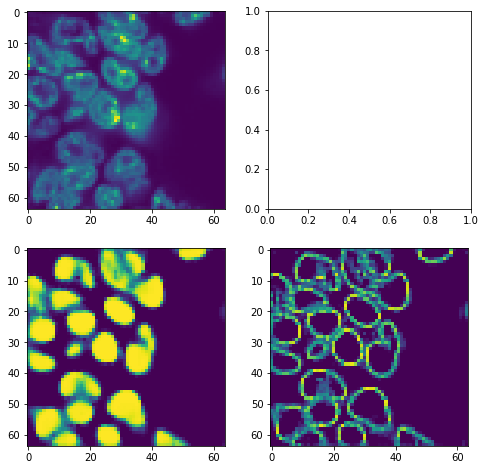

In [145]:
ix=15
results, LN,losses=sess.run([probs, LSQ, loss], feed_dict={x:blobs, y:blobgarb})
f,axes=plt.subplots(2,2, figsize=(8,8))
axes[0,0].imshow(blobs[ix,:,:])
#axes[0,1].imshow(blobgarb[0,:,:,1])
axes[1,0].imshow((0.01+results[ix,:,:,0]))
axes[1,1].imshow((0.5+results[ix,:,:,1]))
ix=ix+1
ix